In [28]:
# Run this block to install dependencies [Remember to make the statement true]
if 0 != 1:
    !pip install pandas
    !pip install tqdm
    !pip install scikit-learn
    !pip install gensim
    !pip install spacy
    !python3 -m spacy download en
    !pip install numpy

^C


'python3' is not recognized as an internal or external command,
operable program or batch file.


In [29]:
from gensim.models.word2vec import Word2Vec


import pandas as pd
import spacy
import pickle
from tqdm import tqdm
from gensim.corpora import Dictionary
from sklearn.utils import shuffle
from collections import defaultdict
import numpy as np

nlp = spacy.load('en')
DATA_LIMIT = 1000

df = pd.read_csv('./imdb_master.csv', encoding='latin1')
df_neg = df[df['label'] == 'neg']
df_pos = df[df['label'] == 'pos']
df = pd.concat((df_pos[:DATA_LIMIT], df_neg[:DATA_LIMIT]))

def process_text(input_string, return_string=False, stem=False):
    text = nlp(u'' + input_string)
    if stem == True:
        text = [tok.lemma_ for tok in text if (tok.is_alpha and not tok.is_stop)]
    else:
        text = [tok.lower_ for tok in text if (tok.is_alpha and not tok.is_stop)]
    if return_string == True:
        return " ".join(text)
    return text

In [30]:
# Make this statement true to run from scratch [It takes time to process the text]
if 1 == 1:
    wordlist = []
    for i in tqdm(range(df.shape[0])):
        wordlist.append(process_text(df['review'].iloc[i]))
        
    with open('vocabulary.txt', 'wb') as vocabulary:
        pickle.dump(wordlist, vocabulary)
    vocabulary.close()

100%|██████████████████████████████████████| 2000/2000 [01:00<00:00, 33.28it/s]


In [36]:
import multiprocessing
word2v_model = Word2Vec(window = 5, workers = multiprocessing.cpu_count(), iter = 100, min_count =1, hs=1, negative=0)

In [37]:
print(word2v_model)

Word2Vec(vocab=0, size=100, alpha=0.025)


In [38]:
word2v_model.build_vocab(wordlist)
print(word2v_model)

Word2Vec(vocab=22171, size=100, alpha=0.025)


In [41]:
%time word2v_model.train(wordlist, total_examples = word2v_model.corpus_count, epochs = word2v_model.epochs)

Wall time: 29.2 s


(18998996, 19737700)

In [43]:
word2v_model.wv['cat'].shape

(100,)

In [44]:
vocabulary = Dictionary(wordlist)

In [45]:
len(vocabulary)

22171

In [59]:
word2v_model.wv.most_similar('bellucci')

[('suitably', 0.4540744423866272),
 ('trauma', 0.3898535966873169),
 ('fogging', 0.37884706258773804),
 ('untangled', 0.3671215772628784),
 ('ambassadors', 0.36553695797920227),
 ('affecting', 0.36449331045150757),
 ('tearjerker', 0.3600119352340698),
 ('slug', 0.35770124197006226),
 ('grasped', 0.35429099202156067),
 ('kali', 0.34955230355262756)]

In [60]:
word2v_model.wv.most_similar(positive=['movie', 'good'], negative=['bad'])

[('film', 0.439160019159317),
 ('movies', 0.41975343227386475),
 ('fact', 0.3750477433204651),
 ('enjoy', 0.36571305990219116),
 ('remembered', 0.3597602844238281),
 ('realistic', 0.35765761137008667),
 ('ese', 0.3412356674671173),
 ('wow', 0.33522793650627136),
 ('cages', 0.32429051399230957),
 ('hinted', 0.3231661319732666)]

In [63]:
"""
1. Create a numpy empty/random matrix with dimension of [Voc size+1 X, Embedding dimension]
2. Load the embeddings into that word
3. Create keras embedding layer with the same configuration and load weights there
4. Train a RNN/CNN to classify
"""

'\n1. Create a numpy empty/random matrix with dimension of [Voc size+1 X, Embedding dimension]\n2. Load the embeddings into that word\n3. Create keras embedding layer with the same configuration and load weights there\n4. Train a RNN/CNN to classify\n'

In [100]:
embedding_dim = 100
embedding = np.zeros((len(vocabulary)+1, embedding_dim))
#embedding[0] = 0
#embedding[1] = word2v_model.wv[ vocabulary[0] ]


for i in range(len(vocabulary)):
        embedding[i+1] = word2v_model.wv[ vocabulary[i] ]

In [87]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense


In [75]:
Embedding??

In [89]:
embd = Embedding(len(vocabulary)+1, output_dim = embedding_dim, weights =[embedding], trainable = False )


In [90]:
print(embd.output_dim)

100


In [91]:
len(wordlist)

2000

In [101]:
X = []
for review in wordlist:
    X.append(np.array(vocabulary.doc2idx(review)) + 1)

In [93]:
from keras.preprocessing.sequence import pad_sequences

In [102]:
train_x = pad_sequences(X, value = 0, maxlen=200)

In [103]:
len(X[0])

57

In [96]:
train_y = np.concatenate((np.ones(1000), np.zeros(1000)))


In [104]:
model = Sequential()
model.add(Embedding(len(vocabulary)+1, output_dim = embedding_dim, weights =[embedding], trainable = False ))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print('Train....')
model.fit(train_x, train_y, batch_size = 128, epochs =15, validation_split=0.3)

Train....
Train on 1400 samples, validate on 600 samples
Epoch 1/15
1400/1400 [==============================] - ETA: 1:19 - loss: 0.7287 - acc: 0.460 - ETA: 40s - loss: 0.7197 - acc: 0.488 - ETA: 26s - loss: 0.7060 - acc: 0.51 - ETA: 18s - loss: 0.6904 - acc: 0.54 - ETA: 13s - loss: 0.6852 - acc: 0.56 - ETA: 10s - loss: 0.6706 - acc: 0.59 - ETA: 7s - loss: 0.6673 - acc: 0.5949 - ETA: 5s - loss: 0.6641 - acc: 0.603 - ETA: 3s - loss: 0.6570 - acc: 0.614 - ETA: 1s - loss: 0.6481 - acc: 0.625 - 18s 13ms/step - loss: 0.6404 - acc: 0.6350 - val_loss: 0.9822 - val_acc: 0.2367
Epoch 2/15
1400/1400 [==============================] - ETA: 7s - loss: 0.5446 - acc: 0.718 - ETA: 6s - loss: 0.5484 - acc: 0.714 - ETA: 6s - loss: 0.5333 - acc: 0.734 - ETA: 5s - loss: 0.5432 - acc: 0.726 - ETA: 4s - loss: 0.5584 - acc: 0.710 - ETA: 3s - loss: 0.5464 - acc: 0.722 - ETA: 3s - loss: 0.5450 - acc: 0.725 - ETA: 2s - loss: 0.5408 - acc: 0.735 - ETA: 1s - loss: 0.5357 - acc: 0.740 - ETA: 0s - loss: 0.5333 - 

In [ ]:
np.array(vocabulary.doc2idx(wordlist[0]))

In [ ]:
for word in vocabulary[:2]:

In [56]:
word2v_model.vocabulary

AttributeError: 'Word2Vec' object has no attribute 'synl'

In [31]:
# Load vocabulary
wordlist = []
with open('vocabulary.txt', 'rb') as vocabulary:
    wordlist = pickle.load(vocabulary) 

In [32]:
# Keeping track of frequency of a single token
frequency = defaultdict(int)
for text in wordlist:
    for token in text:
        frequency[token] += 1
        
# Apply Threshold to limit the vocabulary size, discarding the tokens which appeard number of times below the threshold limit 
FREQ_THRESHOLD = 5

thresholded_wordlist =  [[token for token in text if frequency[token] > FREQ_THRESHOLD]
          for text in wordlist]

# Create Dictionary based on the word list
dictionary = Dictionary(thresholded_wordlist)

# Number of tokens
print("Number of Tokens - {}".format(len(dictionary))) 

Number of Tokens - 5291


![image](https://i.imgur.com/f1uzTDZ.png)

# TODO

* From the screenshot you can see the implementation of word-cooccurance matrix, based on the tokens from the dictionary, build a word-cooccurance matrix yourself which is $X$. Documentation of gensim [https://radimrehurek.com/gensim/corpora/dictionary.html]
* Apply SVD on $X$
* Reduce Dimension 

![dimen_reduc](https://i.imgur.com/lezB870.png)

* Here Richard is taking only top two dimensions of the vector $U$, recommended size is *50* for now.

![dimen_reduc_u](https://i.imgur.com/TA2Bmsq.png)

* Now we can get a fixed size vector for each word. 

* Try to plot something similar based on the given dataset. In class we will try to implement a logistic regression classifier that can classify positive and negative reviews

In [33]:
#From Given corpus build Matrix
len_dic = len(dictionary)
X = np.zeros((len_dic,len_dic))
la = np.linalg
for review in thresholded_wordlist: 
    id = dictionary.doc2idx(review)
    #print(id)
    for i in id:
        for j in id:
            X[i,j] +=1
U,s,Vh = la.svd(X, full_matrices=False)


In [6]:
X[1][0]

3.0

In [7]:
U_sample = U[:,:50]
U_sample.shape

(5464, 50)

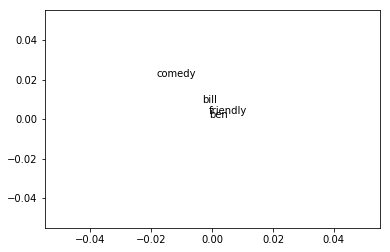

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in [2,100, 4, 56]:
    plt.text(U[i,0], U[i,1], dictionary[i])
    plt.axis("tight")

In [9]:
def SentoVec(sentence):
    #I like this movie. -> [I, like, this, movie] -> doc2idx -> [0, 1, 2, 3] -> U[0, 1, 2, 3], 
    #-> x1 = sum(vec) / len(sentence)	
    l = len(sentence)
    id = dictionary.doc2idx(sentence)
    vec = U_sample[id]
    total_sum = sum(vec)
    return total_sum
        

In [10]:
#Prepare X_train using U vector and doc2idx from gensim corpora [use thresholded wordlist for this]
X_train = []
for review in thresholded_wordlist:
    #Pass each senetence to the funtion and funtion returs probabilty
    X_train.append(SentoVec(review)) 


In [11]:
X_train = np.asarray(X_train)
X_train.shape

(2000, 50)

In [12]:
Y_train = np.zeros(2000)

In [13]:
#Prepare y_train by marking positive review as 1 and negative review as 0
Y_train[:999] = 1 

In [14]:
Y_train.shape

(2000,)

In [15]:
#Train a scikit-learn LogisticRegression classifier using Input and Target Data
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
lr.score(X_train, Y_train)

0.83699999999999997

In [17]:
df_test = pd.concat((df_pos[DATA_LIMIT:1500], df_neg[DATA_LIMIT:1500])) #Test database
if 1 != 0:
    wordlist_test = []
    for i in tqdm(range(df_test.shape[0])):
        wordlist_test.append(process_text(df_test['review'].iloc[i]))

100%|██████████████████████████████████████| 1000/1000 [11:59<00:00,  1.39it/s]


In [18]:
len(wordlist_test)

1000

In [ ]:
X_text = []
for review in wordlist_test:
    X_test.append(word_vector(review))
X_test = np.asarray(X_test)

y_test = np.zeros(1000)
y_test[:500] = 1

X_test.shape, y_test.shape

In [ ]:
LR.score(X_test, y_test)

In [ ]:
y_pred = LR.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

In [4]:
token_2_id = dictionary.token2id
#print(token)
token_2_id['actor']
X = np.zeros((len(dictionary), len(dictionary)))
X.shape

(5464, 5464)

In [8]:
for review in thresholded_wordlist:
    for word in range(len(review)-1):
        #if review[word] in token_2_id.keys() and review[word+1] in token_2_id.keys():
            X[token_2_id[review[word]]][token_2_id[review[word+1]]] += 1
            X[token_2_id[review[word+1]]][token_2_id[review[word]]] += 1
            
X[15][39]

0.0

In [17]:
X = np.zeros((len(dictionary), len(dictionary)))
X.shape
for list in thresholded_wordlist:
    text_to_id = dictionary.doc2idx(list)

    for i in text_to_id:
        for j in text_to_id:
            if(i==j):
                X[i][j] = 0
            X[i][j] += 1


In [19]:
X[1][0]
la = np.linalg
U, s, Vh = la.svd(X, full_matrices=False)

In [ ]:
def sen2word(sentence):
    

In [ ]:
U_New = U[:50]
X_train = []
for sentence in thresholded_wordlist:
    sen2word(sentence)

In [23]:
import matplotlib.pyplot as plt
U.shape
for i in dictionary[1, 500, 0, 50]:
    plt.text(U[i,0], U[i,1], dictionary[i])

KeyError: (1, 500, 0, 50)